# Shape Generation Problem

This is the sixth (and final) toy example from Jason Brownlee's [Long Short Term Memory Networks with Python](https://machinelearningmastery.com/lstms-with-python/). We will train a network to generate rectangles. Per section 11.2 of the book:

> We can frame the problem of generating random shapes as a sequence generation problem. We
can take drawing a rectangle as a sequence of points in the clockwise direction with 4 points in two-dimensional space. So to generatate a rectangle given by the points [BL, BR, TR, TL], the input sequence is [BL, BR, TR] and corresponding output sequence at these timesteps is [BR', TR', TL'].

> Each point can be taken as one time step, with each of the x and y axes representing
separate features. Starting from 0,0, the task is to draw the remaining 3 points of the rectangle with consistent widths and heights. We will frame this problem as a one-coordinate generation problem, e.g. a one-to-one sequence prediction problem. Given a coordinate, predict the next coordinate. Then given the coordinate predicted at the last time step, predict the next coordinate, and so on.

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import os
import shutil
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
MODEL_FILE = os.path.join(DATA_DIR, "torch-11-shape-gen.model")

TRAIN_SIZE = 25000

# model expects 1 timestep input with (x, y) as features
# each batch is sequence of 3 input => 3 output coordinates
# we train for TRAIN_SIZE epochs
SEQ_LENGTH = 1
EMBED_SIZE = 2
BATCH_SIZE = 3

LEARNING_RATE = 1e-3

## Prepare Data

Coordinates corresponding to random rectangles are generated using rules for training the network. Data is generated in (num_epoch, num_batches, sequence_length, num_features) format. This is because we are training the network to generate one coordinate at a time, so each batch corresponds to a single rectangle (3 moves).

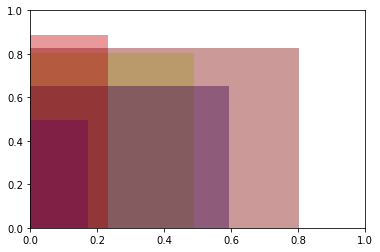

In [3]:
def draw_rectangles(points_seq):
    fig, ax = plt.subplots()
    polygons = []
    for points in points_seq:
        polygons.append(mat.patches.Polygon(points, closed=True, fill=True))
    patches = mat.collections.PatchCollection(polygons, cmap=mat.cm.jet, alpha=0.4)
    colors = 100 * np.random.rand(len(polygons))
    patches.set_array(np.array(colors))    
    ax.add_collection(patches)
    plt.show()

def random_rectangle():
    bl = (0, 0)
    br = (np.random.random(1), bl[1])
    tr = (br[0], np.random.random(1))
    tl = (0, tr[1])
    return [bl, br, tr, tl]

rectangles = []
for i in range(5):
    rectangles.append(random_rectangle())
draw_rectangles(rectangles)

In [4]:
def generate_data(num_recs):
    xseq, yseq = [], []
    for i in range(num_recs):
        rect = random_rectangle()
        xseq.append(np.array(rect[0:-1]))
        yseq.append(np.array(rect[1:]))
    X = np.expand_dims(np.array(xseq, dtype=np.float32), 2)
    Y = np.expand_dims(np.array(yseq, dtype=np.float32), 2)
    return X, Y

Xtrain, Ytrain = generate_data(TRAIN_SIZE)
print(Xtrain.shape, Ytrain.shape)

(25000, 3, 1, 2) (25000, 3, 1, 2)


## Define Network

In [5]:
class ShapeGenerator(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ShapeGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        # network layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, 1, batch_first=True)
        self.fcn = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        if torch.cuda.is_available():
            h = (Variable(torch.randn(1, x.size(0), self.hidden_dim).cuda()),
                 Variable(torch.randn(1, x.size(0), self.hidden_dim).cuda()))
        else:
            h = (Variable(torch.randn(1, x.size(0), self.hidden_dim)),
                 Variable(torch.randn(1, x.size(0), self.hidden_dim)))

        x, h = self.lstm(x, h)
        x = self.fcn(x)
        return x

model = ShapeGenerator(EMBED_SIZE, 10, EMBED_SIZE)
if torch.cuda.is_available():
    model.cuda()
print(model)

# size debugging
print("--- size debugging ---")
inp = Variable(torch.randn(BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE))
outp = model(inp)
print(outp.size())

ShapeGenerator (
  (lstm): LSTM(2, 10, batch_first=True)
  (fcn): Linear (10 -> 2)
)
--- size debugging ---
torch.Size([3, 1, 2])


In [6]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [7]:
history = []
total_loss, prev_loss = 0., None
for epoch in range(TRAIN_SIZE):
    
    Xbatch_data = Xtrain[epoch]
    Ybatch_data = Ytrain[epoch]
    
    Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
    Ybatch = Variable(torch.from_numpy(Ybatch_data).float())
    if torch.cuda.is_available():
        Xbatch = Xbatch.cuda()
        Ybatch = Ybatch.cuda()
    
    # initialize gradients
    optimizer.zero_grad()
    
    # forward
    Ybatch_ = model(Xbatch)
    loss = loss_fn(Ybatch_, Ybatch)
    loss_data = loss.data[0]
    total_loss += loss_data
    
    # backward
    loss.backward()
    
    if epoch > 0 and (epoch % (TRAIN_SIZE // 10) == 0 or epoch == TRAIN_SIZE - 1):
        cum_avg_loss = total_loss / epoch
        history.append((epoch, cum_avg_loss))
        if prev_loss is not None and prev_loss > cum_avg_loss:
            torch.save(model.state_dict(), MODEL_FILE)
        prev_loss = cum_avg_loss
        print("Iteration {:5d}, cum. avg. loss: {:.3f}".format(epoch, cum_avg_loss))

Iteration  2500, cum. avg. loss: 0.244
Iteration  5000, cum. avg. loss: 0.246
Iteration  7500, cum. avg. loss: 0.246
Iteration 10000, cum. avg. loss: 0.245
Iteration 12500, cum. avg. loss: 0.245
Iteration 15000, cum. avg. loss: 0.245
Iteration 17500, cum. avg. loss: 0.245
Iteration 20000, cum. avg. loss: 0.245
Iteration 22500, cum. avg. loss: 0.245
Iteration 24999, cum. avg. loss: 0.245


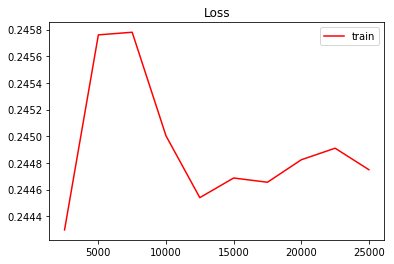

In [8]:
plt.title("Loss")
epochs = [x[0] for x in history]
losses = [x[1] for x in history]
plt.plot(epochs, losses, color="r", label="train")
plt.legend(loc="best")

plt.show()

## Generate Shapes

The trained network is now able to generate approximate rectangles as shown below. We generate 5 "rectangles" starting from (0, 0) in each case and generate the other 3 corners using the model.

In [9]:
saved_model = ShapeGenerator(EMBED_SIZE, 10, EMBED_SIZE)
saved_model.load_state_dict(torch.load(MODEL_FILE))
if torch.cuda.is_available():
    saved_model.cuda()

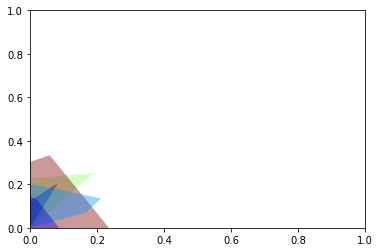

In [12]:
coord_seqs = []
for rect in range(5):
    Xgen = None
    coord_seq = [(0., 0.)]
    for seq in range(3):
        if Xgen is None:
            Xgen_data = np.zeros((1, 1, 2), dtype=np.float32)
            Xgen = Variable(torch.from_numpy(Xgen_data).float())
        else:
            Xgen = Ygen
        
        Ygen = saved_model(Xgen)
        
        if torch.cuda.is_available():
            Ygen_data = Ygen.cpu().data.numpy()
        else:
            Ygen_data = Ygen.data.numpy()
            
        coord_seq.append((Ygen_data[0, 0, 0], Ygen_data[0, 0, 1]))
        
    coord_seqs.append(coord_seq)
    
draw_rectangles(coord_seqs)

In [13]:
os.remove(MODEL_FILE)